# Вариант 1 Russia,11 China

* Построить аддитивную и мультипликативную оценку сезонной компоненты числа 
умерших в каждый день, начиная с 1 сентября 2022 года по 31 декабря 2022.
* Построить графики недельной сезонной компонент с привязкой ко дням недели
* В какой день недели число умерших максимально и минимально?
* Проверить остатки после удаления сезонных компонент на стационарность. 
Выдать P-value соответствующего критерия и вывод о стационарности.
* Оценить показатель Херста к ряду для лагов 7,30,60,90 дней. 
Персистентный или антиперсистентный ряд.
* Построить автокорреляционную функцию для остатков.



In [1]:
# Loading packeges and functions

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

from plotly import express

# Loading data
covid = pd.read_csv('/home/oplora/Documents/VMK/Time Series Analysis/tasks_and_lectures/1.csv')
P_VALUE = 0.05

/tmp/ipykernel_668327/4118175760.py:11: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  covid = pd.read_csv('/home/oplora/Documents/VMK/Time Series Analysis/tasks_and_lectures/1.csv')


In [2]:
# Choosing country
russian_covid = covid[covid['key_apple_mobility'] == 'Russia']

# Choosing time period
pd.to_datetime(russian_covid['date'], format='%Y-%m-%d')

russian_covid = russian_covid.loc[
    (russian_covid['date'] >= '2022-08-31') 
    & (russian_covid['date'] <= '2022-12-31')]
russian_covid

# Exctracting deaths values per day
increments = lambda arr: np.array([arr[i]-arr[i-1] for i in range(1, len(arr))])
time_period = ('2022-09-01', '2022-12-31')
death_increm = increments(russian_covid['deaths'].values)

## Additive estimation

### Seasonal component

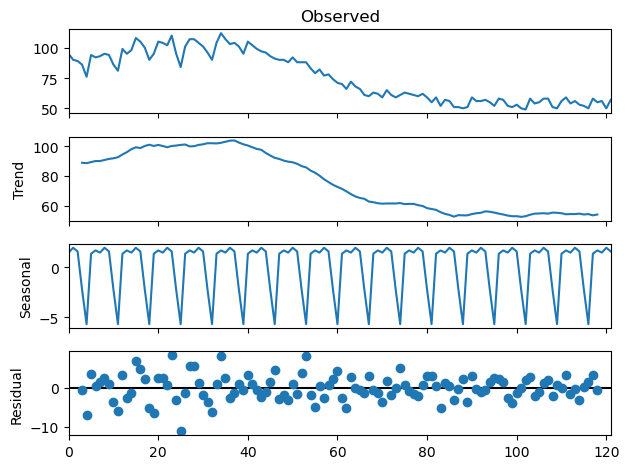

In [3]:
addive_model = seasonal_decompose(
    death_increm, 
    model='additive', 
    period=7
    )
addive_model.plot();

### Weekly seasonal component 

In [4]:
# Checking what was the first day 
from datetime import datetime
print('2022-09-01 is a ', datetime(2022, 9, 1).strftime('%A'))

2022-09-01 is a  Thursday


In [5]:
week_days = [
    'Thu', 
    'Fri',
    'Sat',
    'Sun',
    'Mon',
    'Tue',
    'Wed'
    ]
express.bar(
    x = week_days,
    y = addive_model.seasonal[:7],
    title='Seasonal component of addative model',
    labels=dict(x="Week day", y="Death increment", color="Place")
    )

In [6]:
add_resid = addive_model.resid[~np.isnan(addive_model.resid)]

express.line(
    add_resid, 
    markers=True,
    title='Residuals of addative model'
    )

The highest bar occurs on Friday, e.i. is the day of maximal death cases. 

Similarly, Monday is the day of minimal death occurances.

### Сhecking residuals stationarity

In [7]:
# Using augmented Dickey-Fuller unit root test
add_adf_test = adfuller(add_resid, maxlag=9)
print(
    'Dickey-Fuller unit root test returns -', 
    add_adf_test[1] <= P_VALUE,
    f'(lags = {add_adf_test[2]})')


Dickey-Fuller unit root test returns - True (lags = 8)


As we can see Dickey-Fuller returned p-value less then 0.05. Hence rediduals 
without seasonal component are static.

### Autocorreletion function for resifuals

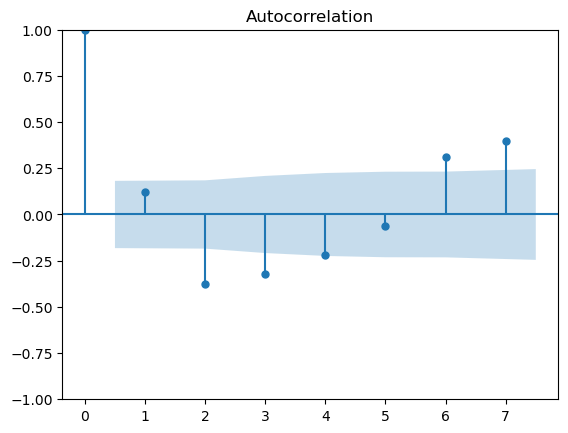

In [8]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(add_resid, lags=7)


Blue region is the confidence interval. The default set confidence interval in the statsmodels library is 95%
Hence, autocorrelation values for lag 2, 3, 6, 7 that lie outside the blue region are statistically significant.
At lag 0 obviously is perfect correlation, so we ignore this lag.
 

## Multiplicative estimation


### Seasonal component

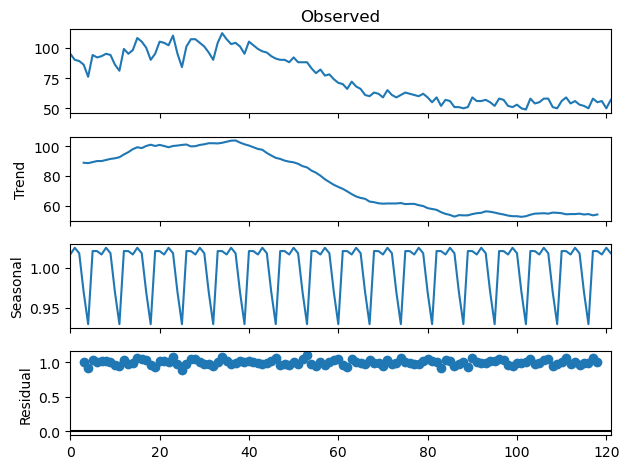

In [9]:
multive_model = seasonal_decompose(
    death_increm, 
    model='multiplicative', 
    period=7
    )
multive_model.plot();

### Weekly seasonal component 

In [10]:
express.bar(
    x = week_days,
    y = multive_model.seasonal[:7],
    title='Seasonal component of addative model',
    labels=dict(x="Week day", y="Death increment", color="Place")
    )

The highest bar occurs on Friday, e.i. is the day of maximal death cases. 

Similarly, Monday is the day of minimal death occurances.

In [11]:
mult_resid = multive_model.resid[~np.isnan(multive_model.resid)]

fig = express.line(
    mult_resid, 
    markers=True,
    title='Residuals of addative model'
    )
fig.update_xaxes(
        title_text = "Days")

fig.show()

### Сhecking residuals stationarity

In [12]:
# Using augmented Dickey-Fuller unit root test
mult_adf_test = adfuller(mult_resid, maxlag=9)
print(
    'Dickey-Fuller unit root test returns -', 
    mult_adf_test[1] <= P_VALUE,
    f'(lags = {mult_adf_test[2]})')


Dickey-Fuller unit root test returns - True (lags = 8)


As we can see Dickey-Fuller returned p-value less then 0.05. Hence rediduals 
without seasonal component are static.

### Autocorreletion function for residuals

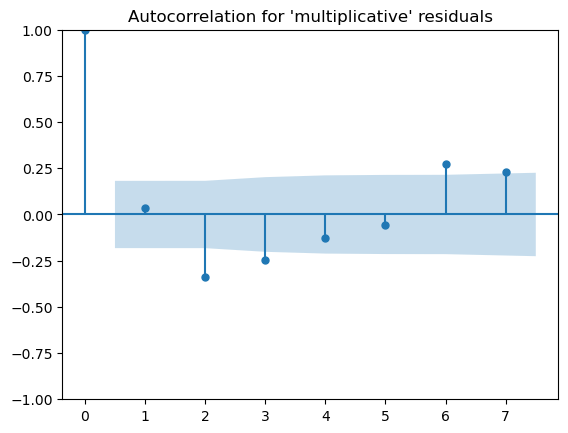

In [13]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(
    mult_resid, 
    lags=7,
    title='Autocorrelation for \'multiplicative\' residuals'
    )


Blue region is the confidence interval. The default set confidence interval in the statsmodels library is 95%.
Here we may see similar plot as for additive model. Autocorrelation values for 
lag 2, 3, 6, 7 that lie outside the blue region are statistically significant
 

## Herston exponent for death increments

In [14]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

for lag in [7,30,60,90]:
    hurst_exp = get_hurst_exponent(death_increm, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 7 lags: 0.0238
Hurst exponent with 30 lags: 0.3935
Hurst exponent with 60 lags: 0.3081
Hurst exponent with 90 lags: 0.0565


For each log calculated Hurst exponent is less then 0.5. It means that death 
increments are not tend to return to their mean value:
* for maxlag equal 7 or 90 time series are evidently antipersistence
* for others maxlags antipersistence is not that strong